Loading data (MatExample)

In [1]:
import scipy.io
import numpy as np
import os
os.chdir('C:\\Users\\adam1brownell' + '\Documents\Dev101\MontiLab')

subj = "01" #Within Subject Models

#AB Data Load
abLoad = scipy.io.loadmat("sub-"+subj+"_task-analogy_ab-betas-ba10.mat")
abData    = abLoad["data"]      # actual data (numpy array)
abAnalogy = abLoad["trial_id"]  # actual analogy they saw
abArray   = abLoad["main_rel"]  # main relationship (1,2,3)
abRel     = [abArray[0,i][0]for i in range(288)] #I'm cheating and now there are 288 examples
abSub     = abLoad["sub_rel"]   # sub relationship (1-9)

#CD Data Load
cdLoad = scipy.io.loadmat("sub-"+subj+"_task-analogy_cd-betas-ba10.mat")
cdData    = cdLoad["data"]      # actual data (numpy array)
cdAnalogy = cdLoad["trial_id"]  # actual analogy they saw
cdArray   = cdLoad["main_rel"]  # main relationship (1,2,3)
cdRel     = [cdArray[0,i][0]for i in range(288)] #I'm cheating and now there are 288 examples
cdSub     = cdLoad["sub_rel"]   # sub relationship (1-9)


In [2]:
# Load Human Data
import pandas as pd

humanData = pd.read_csv('C:\\Users\\adam1brownell\\Desktop\\humanratings.csv', header = 2)
humanData.columns = humanData.columns.str.replace(humanData.columns[0],'Analogy')

In [3]:
# Word2Vec can represent the way the brain stores analogous relations
# Ridge Regression on the Imported data

In [4]:
# Pipeline

# Input of a new dataset
# For each voxel:
    # Test correlation of each voxel output to the feature
    # Ridge regression with y being the voxel and x being input data

In [5]:
humanData.head()

,Analogy,Synonymity,AttributeSimilarity,Change,Contrary,Directional,Pseudoantonym,Cause:Effect,Cause:CompensatoryAction,Action/Activity:Goal
0,house:home,0.088388,0.001103,0.001103,0.0,0.0,0.0,0.0,0.0,0.0
1,kid:child,0.088141,0.001103,0.001103,0.0,0.0,0.0,0.0,0.0,0.0
2,raise:elevate,0.087645,0.001103,0.001103,0.0,0.0,0.0,0.0,0.0,0.0
3,teach:instruct,0.079970,0.001103,0.001103,0.0,0.0,0.0,0.0,0.0,0.0
4,big:large,0.077990,0.001103,0.001103,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Load Voxel Data
%matplotlib inline
projecttitle = 'Analogy'
import sys
sys.path.append(os.path.join("/Users", "adam1brownell", "Documents", "GitHub", "task-fmri-utils"))

import fmri_core as pa
import numpy as np
# Load Entire Grey Matter
imgFile= "C:\\Users\\adam1brownell\\Documents\\GitHub\\task-fmri-utils\\analogy001_grayMatter_betas_LSA.nii"
labFile=  "C:\\Users\\adam1brownell\\Documents\\GitHub\\task-fmri-utils\\sub-01_task-analogy_events-pymvpa.tsv"
mask=    "C:\\Users\\adam1brownell\\Documents\\GitHub\\task-fmri-utils\\aal-LOFC-bin_mask.nii"

maskedImg = pa.utils.maskImg(imgFile, mask)
labels = pa.utils.loadLabels(labFile, sep='\t', index_col=0)

#Apply Mask
maskr = pa.utils.loadImg(mask)
imgr = pa.utils.loadImg(imgFile)
maskd = np.array(maskr.get_data())
imgd = np.array(imgr.get_data())

Masking C:\Users\adam1brownell\Documents\GitHub\task-fmri-utils\analogy001_grayMatter_betas_LSA.nii
Loading label file from: C:\Users\adam1brownell\Documents\GitHub\task-fmri-utils\sub-01_task-analogy_events-pymvpa.tsv
Reading file from: C:\Users\adam1brownell\Documents\GitHub\task-fmri-utils\aal-LOFC-bin_mask.nii
Reading file from: C:\Users\adam1brownell\Documents\GitHub\task-fmri-utils\analogy001_grayMatter_betas_LSA.nii


array([ 20.60161972, -29.19544601,   7.21172047, ...,   0.        ,
         0.        ,   0.        ])

In [58]:
# analogOrder is a function that scrapes the AB analogy from each trial in
# labels and then adds the row that corresponds to that analogy

# It currently assumes that newData is a panda with a column entitled 'Analogy'
# Reminder that labels will have more rows that newData since they ran the experiment

def analogyOrder(newData,labels, regex = False):
    
    analogyDF = pd.DataFrame() #Initialize empty DF
    
    #If we need to parse the data...
    if(regex):
        import re
        for row in range(len(labels)): #For every trial in the testing data...

                # Pull analogy for analogy pair, which is saved 'word1:word2::word3:word4' for AB + CD trials
                analogy = re.split("::", labels.trialtag[row])[0]

                # Find appropriate analogy data from newData and append to new DF
                newAnalogy = newData.loc[newData['Analogy'] == analogy]
                analogyDF = pd.concat([analogyDF,newAnalogy])
            
    # If the labels are nice/ already parsed
    else:
        
        for i in range(len(labels)): #For every trial in the testing data...
        
            analogy = labels.abtag[i]
            # Find appropriate analogy data from newData and append to new DF
            newAnalogy = newData.loc[newData['Analogy'] == analogy]
            analogyDF = pd.concat([analogyDF,newAnalogy])
            
            
            
    return analogyDF
        
        

In [109]:
# searlightCorr calculates correlation of newData to each voxel from fMRI voxels
# This is done by running Ridge regression on both the newData and 
# a dummy regressor, where x = data and y = voxel value per trial


# TODO: Run a test to see how it will perform!

# TODO: Change voxel data to just AB voxel data

def searchlightCorr(newData, voxelData, labels):
    from sklearn import preprocessing
    from sklearn.linear_model import Ridge
    from sklearn.dummy import DummyRegressor #It is a regressor because voxel values are continuous
    
    
    # new Data should be [n x m] matrix of prediction
    # voxel Data should be [n x z] matrix of voxel outputs
    
    # Quickly cut labels + Voxels down into just AB trials
    abLabels = labels[labels.ab == 1]
    vData = voxelData[abLabels.index,:]
    indx = [i for i in range(len(abLabels))]
    abLabels.index = indx
    
    #orderedData will be a DF that is in the correct order of analogy pairs, according to voxel labels
    print('Reorderiing Analogies...')
    orderedData = analogyOrder(newData,abLabels)
    
    #Crop out analogy column, which is the first column.
    filterData = orderedData.loc[:,orderedData.columns[1:]]
    
    RSSList = [] #Will hold RSS 
    CorrList = [] #Will hold difference between dummy and new data
    # Scale newData
    scaleData = preprocessing.scale(filterData)
    
    print('Running Searchlight...')
    for col in range(vData.shape[1]):     # this spits out columns from voxel data
        vox = vData[:,col]                # Voxels are the columns
        ridge = Ridge()
        dummy = DummyRegressor()
        
        # Fit Ridge + dummy versus this vox
        ridge.fit(scaleData,vox)
        dummy.fit(scaleData,vox)
        
        # Predict
        ridgePred = ridge.predict(scaleData)
        dummyPred = dummy.predict(scaleData)
        
        # Score
        ridgeR2 = ridge.score(scaleData,vox)
        dummyR2 = dummy.score(scaleData,vox)
        #ridgeRSS = sum((ridgePred-vox)**2)
        #dummyRSS = sum((dummyPred-vox)**2)
        
        # Find difference and add to list
        RSSList.append(ridgeR2)
        CorrList.append(ridgeR2-dummyR2)
        
        #RSSList.append(ridgeRSS)
        #CorrList.append(ridgeRSS-dummyRSS)
        
    import matplotlib.pyplot as plt
    
    #Build X axis as long as number of voxels
    voxList = [i for i in range(vData.shape[1])]
    
    #Plot both ridge RSS and difference
    plt.plot(voxList,RSSList, 'b', label = 'RSS')
    plt.plot(voxList, CorrList, 'r', label = 'Performance vs. Dummy')
    plt.ylim([-1,1])
    plt.title("Correlation per Voxel")
    
    #Print Cumulative Success
    
    print("Data Performance: ",float(sum(RSSList))/len(RSSList) )
    print("Dummy Performance: ",float(sum([RSSList[i] - CorrList[i] for i in range(len(RSSList))])/len(RSSList)) )
    
        
        
# TODO: Unmasked
# pa.util.unmaskImg
    

Reorderiing Analogies...
Running Searchlight...
Data Performance:  0.06011395463484811
Dummy Performance:  0.031651436895775396


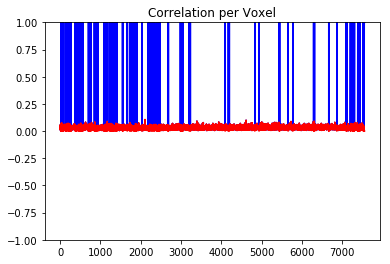

In [110]:
searchlightCorr(humanData,maskedImg,labels)

In [81]:
abLabels = labels[labels.ab == 1]
x = maskedImg[abLabels.index,:]

(288, 7551)

In [108]:
import matplotlib.pyplot as plt

In [ ]:
plt.ylim